In [9]:
# Libraries used
using DataFrames;
using CSV;
using StatsPlots;
using Plots;
using Statistics;

# Load dataset 

In [15]:
dataset = CSV.read("support2.csv", DataFrame, delim = ',');
dataset = select(dataset, Not("id"))
numRows, numCols = size(dataset)

println("Number of instances: ", numRows)
println("Number of features: ", numCols)

Number of instances: 9105
Number of features: 47


# Descriptive analysis

Based on the description of the dataset and the previous section we can divide the information in three classes:

- **Categorical**: These variables are non-continuos and usually represents different categories, for example, sex of the patient (`sex`).

- **Ordinal**: These variables are similar to the categorical ones, but in this case there is an order of importance between the categories, for example, the index of disability of the patient (`sfdm2`).

- **Numerical**: These variables are continuos, usually representing a measure, for example, the charges of the patient to the hospital (`charges`). 

In [16]:
# Craft new target variable
dataset[:,"hospdeath"] = dataset[:,"death"] + dataset[:,"hospdead"] 

# Names 
targetName = ["death", "hospdead", "hospdeath"];
ordNames = ["edu", "income", "sfdm2", "ca", "adlp", "adls", "adlsc"];
catNames = ["sex", "dzgroup", "dzclass", "race", "dnr", "dementia", "diabetes"];
numNames = num_feats = names(select(dataset, Not(ordNames, targetName, catNames)), Union{Missing, Number});

println("Target name: ", targetName);
println();
println("Ordinal features (", length(ordNames), "): ", ordNames);
println("Numerical features (", length(numNames), "): ", numNames);
println("Categorical features (", length(catNames), "): ", catNames);

# Partition by data type to perform preprocessing
targetDataset = select(dataset, targetName);
catDataset = select(dataset, catNames);
numDataset = select(dataset, Not(targetName, catNames));

Target name: ["death", "hospdead", "hospdeath"]

Ordinal features (7): ["edu", "income", "sfdm2", "ca", "adlp", "adls", "adlsc"]
Numerical features (31): ["age", "slos", "d.time", "num.co", "scoma", "charges", "totcst", "totmcst", "avtisst", "sps", "aps", "surv2m", "surv6m", "hday", "prg2m", "prg6m", "dnrday", "meanbp", "wblc", "hrt", "resp", "temp", "pafi", "alb", "bili", "crea", "sod", "ph", "glucose", "bun", "urine"]
Categorical features (7): ["sex", "dzgroup", "dzclass", "race", "dnr", "dementia", "diabetes"]


In [17]:
println("Descriptive analysis of the target: ")
summaryTarget = describe(targetDataset);
show(summaryTarget[:, ["variable", "nmissing", "eltype", "mean"]], allrows=true, allcols=true);

Descriptive analysis of the target: 
3×4 DataFrame
 Row │ variable   nmissing  eltype    mean     
     │ Symbol     Int64     DataType  Float64  
─────┼─────────────────────────────────────────
   1 │ death             0  Int64     0.681054
   2 │ hospdead          0  Int64     0.259198
   3 │ hospdeath         0  Int64     0.940253

In [18]:
println("Descriptive analysis of the numerical inputs: ")
summaryNum = describe(numDataset);
show(summaryNum[:,["variable", "nmissing", "eltype", "min", "max", "mean"]], allrows=true, allcols=true);

Descriptive analysis of the numerical inputs: 
38×6 DataFrame
 Row │ variable  nmissing  eltype                    min               max                  mean     
     │ Symbol    Int64     Type                      Any               Any                  Union…   
─────┼───────────────────────────────────────────────────────────────────────────────────────────────
   1 │ age              0  Float64                   18.042            101.848              62.6508
   2 │ slos             0  Int64                     3                 343                  17.863
   3 │ d.time           0  Int64                     3                 2029                 478.45
   4 │ num.co           0  Int64                     0                 9                    1.86864
   5 │ edu           1634  Union{Missing, Int64}     0                 31                   11.7477
   6 │ income        2982  Union{Missing, String15}  $11-$25k          under $11k                    
   7 │ scoma            1  Union

In [19]:
println("Descriptive analysis of the categorical: ")
summaryCat = describe(catDataset);
show(summaryCat[:, ["variable", "nmissing", "eltype", "min", "max"]], allrows=true, allcols=true);

Descriptive analysis of the categorical: 
7×5 DataFrame
 Row │ variable  nmissing  eltype                    min                max          
     │ Symbol    Int64     Type                      Any                Any          
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │ sex              0  String7                   female             male
   2 │ dzgroup          0  String31                  ARF/MOSF w/Sepsis  MOSF w/Malig
   3 │ dzclass          0  String31                  ARF/MOSF           Coma
   4 │ race            42  Union{Missing, String15}  asian              white
   5 │ dnr             30  Union{Missing, String15}  dnr after sadm     no dnr
   6 │ dementia         0  Int64                     0                  1
   7 │ diabetes         0  Int64                     0                  1

Based on the previous analysis we spot some problems with the features:

- **Ordinal features**:
    - `income`, `sfdm2` and `ca` are not correctly encoded. As this variables represent importance levels, they should be encoded as integers ordered in ascendant by their import

- **Categorical**:
    - `sex`, `dzgroup`, `dzclass`, `race`, `ca`, `dnr` are encoded as strings, so they should be one-hot encoded.

- **Numerical**: 
    - Standarization should be performed to scale data, min-max wont work ok since our data could contain outliers since we are treating terminal ill patients.

# Visualizations

- Are classes unbalanced?

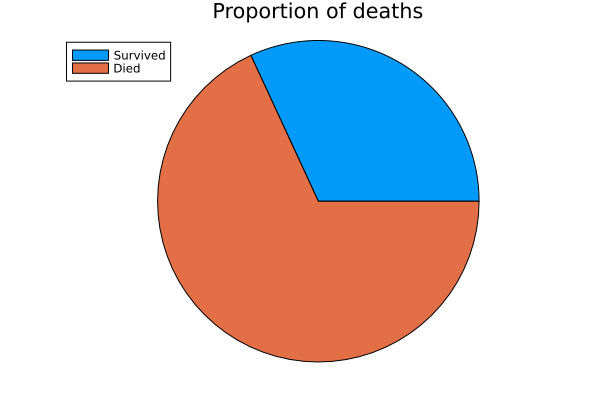

In [37]:
value_counts = combine(groupby(dataset, :death), nrow => :count)
labels = ["Survived", "Died"] 
values = value_counts.count   

pie(labels, values, title="Proportion of deaths", autopct="%1.1f%%")

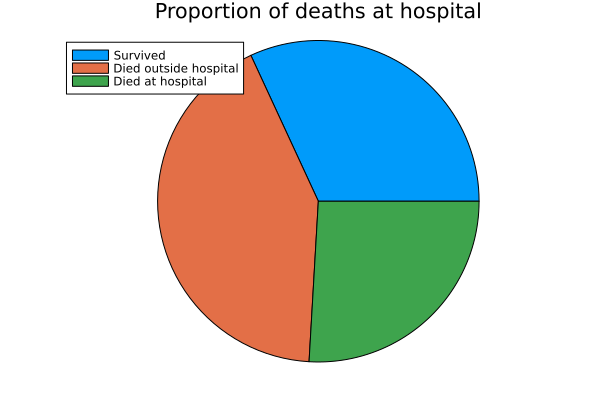

In [48]:
dataset[:,"hospdeath"] = dataset[:,"death"] + dataset[:,"hospdead"] 
value_counts = combine(groupby(dataset, :hospdeath), nrow => :count)
labels = ["Survived", "Died outside hospital", "Died at hospital"]
values = value_counts.count
pie(labels, values, title="Proportion of deaths at hospital", autopct="%1.1f%%")

- Does the death depend on the gender of the patient?

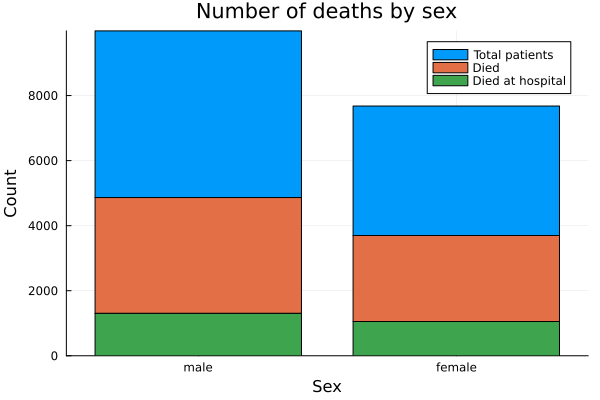

In [41]:
value_counts = combine(groupby(dataset, :sex), nrow => :count,
                                              :death => sum => :sum_dead,
                                              :hospdead => sum => :sum_hosp_dead)
labels = value_counts.sex;  
total = value_counts.count;   
deaths = value_counts.sum_dead;
deaths_hosp = value_counts.sum_hosp_dead;
groupedbar(labels, [total deaths deaths_hosp], xlabel = "Sex", ylabel = "Count",
    title = "Number of deaths by sex",  bar_position = :stack,
    label = ["Total patients" "Died" "Died at hospital"], legend = true)

- Does the death depend on the income of the patient?

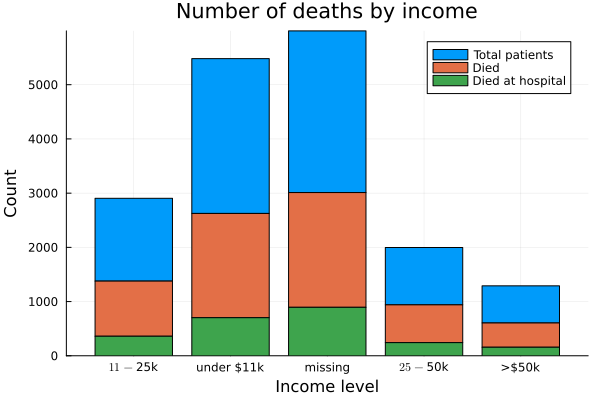

In [40]:
value_counts = combine(groupby(dataset, :income), nrow => :count,
                       :death => sum => :sum_dead,
                       :hospdead => sum => :sum_hosp)
labels = value_counts.income;   # Etiquetas
deaths = value_counts.sum_dead;
hosp = value_counts.sum_hosp;
total = value_counts.count;   # Frecuencias
groupedbar(labels, [total deaths hosp], xlabel = "Income level", ylabel = "Count",
    title = "Number of deaths by income", bar_position = :stack,
    label = ["Total patients" "Died" "Died at hospital"], legend = true)

- Are features correlated?

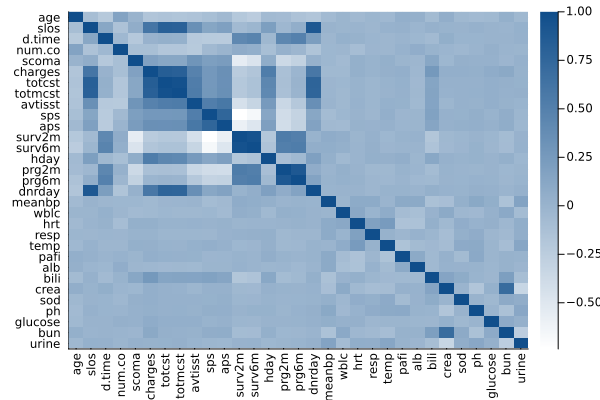

In [ ]:
dataset_clean = dropmissing(dataset, numNames)
M = cor(Matrix(dataset_clean[:, numNames]))
(n,m) = size(M)

heatmap(M, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,numNames), xrot=90, yticks=(1:m,numNames), yflip=true)